# imports

In [3]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os

2025-07-28 14:57:43.979127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 14:57:43.979500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 14:57:43.981627: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 14:57:43.986986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753702063.996848   55387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753702063.99

# pathes

In [1]:
train_path = '/kaggle/input/big-dog-and-cat-dataset/'
test_path = '/kaggle/input/dog-and-cat/data/'

# import data

In [ ]:
file_list1 = [f for f in os.listdir(train_path + 'train/')]
df1 = pd.DataFrame({'filename': file_list1})
df1['label'] = df1['filename'].apply(lambda x: x.split('.')[0])
print(df1.head())

NameError: name 'os' is not defined

# data generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_dataframe(
    dataframe=df1,
    directory='/kaggle/input/big-dog-and-cat-dataset/train/', 
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary' 
)

validation = val_datagen.flow_from_directory(
    test_path + 'validation',
    target_size=(256, 256),
    batch_size=128,
    class_mode='binary'
)
test = test_datagen.flow_from_directory(
    test_path + 'test',
    target_size=(256, 256),
    batch_size=128,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras import optimizers
import keras_tuner as kt

# random hyperparameter

In [ ]:
def build_model(hp):    
    model = Sequential()
    model.add(Input(shape=(256, 256, 3)))
    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=16, max_value=48, step=16),
    kernel_size=hp.Choice('conv1_kernel', values=[3,5]), 
    strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=64, step=16),
    kernel_size=hp.Choice('conv2_kernel', values=[3,5]), 
    strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=16),
    kernel_size=hp.Choice('conv3_kernel', values=[3]), 
    strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv4_filters', min_value=128, max_value=256, step=16),
    kernel_size=hp.Choice('conv4_kernel', values=[3]), 
    strides=1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.3, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='./my_tuner_dir',
    project_name='random_search'
)

2025-07-28 09:38:08.338829: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
history = tuner.search(
    train,
    epochs=30,
    validation_data=validation,
    steps_per_epoch=len(train),
    validation_steps=len(validation))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,710,177 (14.15 MB)

 Trainable params: 3,710,145 (14.15 MB)

 Non-trainable params: 32 (128.00 B)

# get best model

In [ ]:
hist = history.trials[0].metrics.get_history('val_accuracy')
trial0_history = history.trials[0].metrics.get_history('accuracy')
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    train,
    epochs=10,
    validation_data=validation,
    steps_per_epoch=len(train),
    validation_steps=len(validation)
)

# plot of accuracy

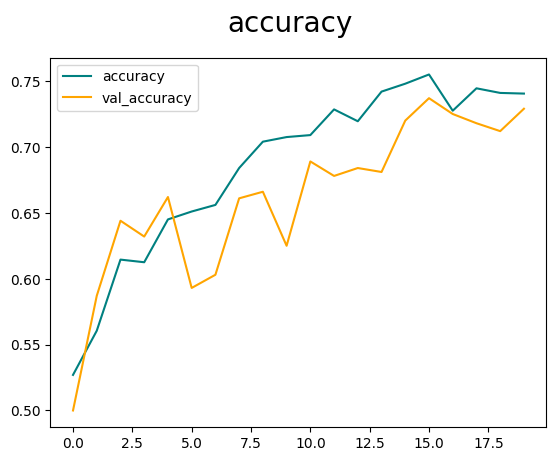

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# test model

In [ ]:
results = best_model.evaluate(
    test,
    steps=len(test)
)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7488 - loss: 0.5149
0.7475000023841858
